In [1]:
import pandas as pd

from mlforecast import MLForecast
from statsforecast import StatsForecast
from sklearn.linear_model import LinearRegression
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM, LSTM
from neuralforecast.losses.pytorch import MQLoss
import matplotlib.pyplot as plt

from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive
)

def create_date_format(
        df: pd.DataFrame, original_date_column: str
    ) -> pd.DataFrame:
        """
        Creates a pandas datetime object from a date string.
        Very specifiy to the output of the mdb notebook yrmo column.
        """
        df["yyyymm"] = df[original_date_column].apply(
            lambda x: str(x)[:4] + "-" + str(x)[4:] + "-01"
        )
        df["yyyymm"] = pd.to_datetime(df.yyyymm)
        return df

/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/fra_eylea_20230215.csv')
df = create_date_format(df, 'yrmo')

df_nixtla = df[['cstmr_1_id', 'yyyymm', 'sales_unit','f2f_calls', 'remote_calls','ae_sent','evnt_invited', 'total_hcp_cnt']]
df_nixtla.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)

#df_nixtla['test'] = df_nixtla.groupby('unique_id').y.shift(-5)

In [3]:
# lstm search spacce:

horizon=6

config_lstm = dict(
    input_size=tune.choice([horizon*1, horizon*2]),              # Length of input window
    encoder_hidden_size=tune.randint(100, 300),            # Hidden size of LSTM cells
    encoder_n_layers=tune.randint(2,5),                   # Number of layers in LSTM
    encoder_dropout=tune.loguniform(0.01, 0.7),
    decoder_hidden_size=tune.randint(100, 300),  # size of hidden layer for the MLP decoder.
    decoder_layers=tune.randint(2, 5),   # number of layers for the MLP decoder
    learning_rate=tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    scaler_type=tune.choice(['robust', 'standard']),                   # Scaler type
    max_steps=tune.randint(500, 1500),                    # Max number of training iterations
    batch_size=tune.choice([16, 32, 64, 128]),                        # Number of series in batch
    num_lr_decays=tune.loguniform(0.01, .2),
    # random_seed= tune.randint(1, 20),                       # Random seed
    hist_exog_list=['f2f_calls', 'remote_calls','ae_sent','evnt_invited','total_hcp_cnt'],
    futr_exog_list =[],
    #stat_exog_list = ['total_hcp_cnt']
)

model = [AutoLSTM(h=horizon,
                  config=config_lstm, 
                  #futr_exog_list = ['gen_forecast', 'week_day'], # <- Future exogenous variables
                  #hist_exog_list = ['total_calls'], # <- Historical exogenous variables
                  #stat_exog_list = ['market_0', 'market_1'], # <- Static exogenous variables
                  loss = MQLoss(),
                  num_samples=10, # number of configurations explored --> ideally above 25,
                  search_alg=HyperOptSearch())
         ]

In [4]:
df_nixtla2 = df_nixtla[df_nixtla.ds<='2022-05-01'].copy()

nf = NeuralForecast(
     models=model,
     freq='MS')

val_size  = 18 # 3 x 6 months
test_size = 6 # 1 x 6 months

Y_hat_df = nf.cross_validation(df=df_nixtla2, 
                               val_size=val_size,
                               test_size=test_size, 
                               n_windows=None)

(_train_tune pid=7782) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 61.77it/s, v_num=0, train_loss_step=0.197, train_loss_epoch=0.236]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 80.85it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 77.96it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 77.78it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 77.79it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 77.68it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 77.76it/s]
(_train_tune pid=7782) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 62.27it/s, v_num=0, train_loss_step=0.196, train_loss_epoch=0.193, valid_loss=6.770]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 84.02it/s]
(_train_tune 

2023-10-31 09:11:07,498	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=7782) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 92.17it/s, v_num=0, train_loss_step=0.312, train_loss_epoch=0.370] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 104.57it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 98.85it/s]
(_train_tune pid=7782) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 94.72it/s, v_num=0, train_loss_step=0.284, train_loss_epoch=0.368, valid_loss=7.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 104.78it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 104.98it/s]
(_train_tune pid=7782) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 93.85it/s, v_num=0, train_loss_step=0.484, train_loss_epoch=0.339, valid_loss=7.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=7782) 
Validation

2023-10-31 09:11:14,598	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 21:  96%|█████████▌| 23/24 [00:00<00:00, 94.32it/s, v_num=0, train_loss_step=0.321, train_loss_epoch=0.343, valid_loss=6.880]


(_train_tune pid=7782) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 106.06it/s, v_num=0, train_loss_step=0.265, train_loss_epoch=0.341] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 138.13it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 138.03it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 137.29it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 137.59it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 137.60it/s]
(_train_tune pid=7782) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 97.33it/s, v_num=0, train_loss_step=0.278, train_loss_epoch=0.330, valid_loss=6.690]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 123.36it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 123.61it/s]
(_trai

2023-10-31 09:11:24,090	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 14:  88%|████████▊ | 42/48 [00:00<00:00, 55.63it/s, v_num=0, train_loss_step=0.234, train_loss_epoch=0.284, valid_loss=8.770]


(_train_tune pid=7782) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 53.05it/s, v_num=0, train_loss_step=0.382, train_loss_epoch=0.338]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 80.14it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 76.51it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 78.37it/s]
(_train_tune pid=7782) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 53.81it/s, v_num=0, train_loss_step=0.312, train_loss_epoch=0.347, valid_loss=6.830]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 79.74it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 77.18it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 78.56it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 78.58it/s]
(_train_tune 

2023-10-31 09:11:47,289	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 42:  25%|██▌       | 6/24 [00:00<00:00, 54.32it/s, v_num=0, train_loss_step=0.258, train_loss_epoch=0.291, valid_loss=9.210]


(_train_tune pid=7782) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 83.59it/s, v_num=0, train_loss_step=0.317, train_loss_epoch=0.339] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 98.36it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 96.04it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 97.26it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 97.67it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 97.49it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 97.86it/s]
(_train_tune pid=7782) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 95.14it/s, v_num=0, train_loss_step=0.290, train_loss_epoch=0.343, valid_loss=7.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 113.62it/s]
(_train_tun

2023-10-31 09:12:08,760	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 28:  38%|███▊      | 18/48 [00:00<00:00, 86.84it/s, v_num=0, train_loss_step=0.245, train_loss_epoch=0.272, valid_loss=9.240]


(_train_tune pid=7782) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 70.40it/s, v_num=0, train_loss_step=0.309, train_loss_epoch=0.355]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 63.98it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 63.57it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 63.44it/s]
(_train_tune pid=7782) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 68.41it/s, v_num=0, train_loss_step=0.286, train_loss_epoch=0.374, valid_loss=7.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 81.04it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 78.53it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  62%|██████▎   | 15/24 [00:00<00:00, 77.99it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 79.03it/s]
(_train_tune 

2023-10-31 09:12:29,638	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 49:  17%|█▋        | 4/24 [00:00<00:00, 63.49it/s, v_num=0, train_loss_step=0.355, train_loss_epoch=0.391, valid_loss=7.270]


(_train_tune pid=7782) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 78.24it/s, v_num=0, train_loss_step=0.272, train_loss_epoch=0.353] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 92.56it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 96.46it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 96.46it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 96.37it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 95.80it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 95.86it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 96.08it/s]
(_train_tune pid=7782) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 40.05it/s, v_num=0, train_loss_step=0.273, train_loss_epoch=0.351, valid_loss=7.370]
Validation: |          | 0/? [00:

2023-10-31 09:12:59,966	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 31:  19%|█▉        | 9/48 [00:00<00:00, 83.08it/s, v_num=0, train_loss_step=0.404, train_loss_epoch=0.357, valid_loss=7.350]


(_train_tune pid=7782) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 60.61it/s, v_num=0, train_loss_step=0.271, train_loss_epoch=0.353]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 77.36it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 78.38it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 78.32it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 79.48it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 80.69it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 81.31it/s]
(_train_tune pid=7782) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 65.61it/s, v_num=0, train_loss_step=0.273, train_loss_epoch=0.351, valid_loss=7.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 88.00it/s]
(_train_tune 

2023-10-31 09:13:27,005	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=7782) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 82.67it/s, v_num=0, train_loss_step=0.312, train_loss_epoch=0.369]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 95.71it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 96.83it/s]
(_train_tune pid=7782) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 86.06it/s, v_num=0, train_loss_step=0.283, train_loss_epoch=0.366, valid_loss=7.000] 
(_train_tune pid=7782) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  42%|████▏     | 10/24 [00:00<00:00, 98.94it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 98.22it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 98.10it/s]
(_train_tune pid=7782) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00

2023-10-31 09:13:39,065	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 73.21it/s]


(_train_tune pid=7782) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 84.48it/s, v_num=0, train_loss_step=0.191, train_loss_epoch=0.192]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 122.62it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 121.73it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 121.65it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 121.67it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 121.54it/s]
(_train_tune pid=7782) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 83.88it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.186, valid_loss=6.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 122.26it/s]
(_train_tune pid=7782) 
Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 120.47it/s]
(_trai

2023-10-31 09:13:49,465	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
Seed set to 1


Epoch 13:  79%|███████▉  | 38/48 [00:00<00:00, 81.48it/s, v_num=0, train_loss_step=0.194, train_loss_epoch=0.173, valid_loss=9.840]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [5]:
nf.models[0].results.get_best_result().config

{'input_size': 6,
 'encoder_hidden_size': 156,
 'encoder_n_layers': 3,
 'encoder_dropout': 0.24930468983520415,
 'decoder_hidden_size': 182,
 'decoder_layers': 3,
 'learning_rate': 0.0015243052513050372,
 'scaler_type': 'robust',
 'max_steps': 835,
 'batch_size': 32,
 'num_lr_decays': 0.14220459716680392,
 'hist_exog_list': ('f2f_calls',
  'remote_calls',
  'ae_sent',
  'evnt_invited',
  'total_hcp_cnt'),
 'futr_exog_list': (),
 'h': 6,
 'loss': MQLoss(),
 'valid_loss': MQLoss()}

In [6]:
nf.fit(df=df_nixtla2)

(_train_tune pid=11201) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 62.88it/s, v_num=0, train_loss_step=0.201, train_loss_epoch=0.253]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 69.15it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 71.29it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 71.53it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 69.43it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 69.33it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 69.48it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 69.78it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 69.89it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:0

2023-10-31 09:14:34,120	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 21:  46%|████▌     | 22/48 [00:00<00:00, 30.91it/s, v_num=0, train_loss_step=0.197, train_loss_epoch=0.181, valid_loss=5.910]


(_train_tune pid=11201) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 83.75it/s, v_num=0, train_loss_step=0.433, train_loss_epoch=0.436] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 93.55it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 23.96it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:01<00:00, 17.76it/s]
(_train_tune pid=11201) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 91.33it/s, v_num=0, train_loss_step=0.341, train_loss_epoch=0.460, valid_loss=5.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 79.77it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 79.07it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 78.44it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 78.59it/s]
(_train

2023-10-31 09:14:46,112	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 21:  96%|█████████▌| 23/24 [00:00<00:00, 87.93it/s, v_num=0, train_loss_step=0.237, train_loss_epoch=0.407, valid_loss=4.520]


(_train_tune pid=11201) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 107.52it/s, v_num=0, train_loss_step=0.276, train_loss_epoch=0.452] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 126.77it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 128.09it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 130.22it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 130.09it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 130.21it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 130.19it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 129.33it/s]
(_train_tune pid=11201) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 107.45it/s, v_num=0, train_loss_step=0.296, train_loss_epoch=0.391, valid_loss=4.770]
Validation: |     

2023-10-31 09:14:56,486	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=11201) 
Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 129.01it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 128.99it/s]
(_train_tune pid=11201) 
Epoch 14:  79%|███████▉  | 38/48 [00:00<00:00, 52.26it/s, v_num=0, train_loss_step=0.478, train_loss_epoch=0.337, valid_loss=3.560] 


(_train_tune pid=11201) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 53.79it/s, v_num=0, train_loss_step=0.320, train_loss_epoch=0.433] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 75.83it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 76.29it/s]
(_train_tune pid=11201) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 54.75it/s, v_num=0, train_loss_step=0.329, train_loss_epoch=0.371, valid_loss=5.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 77.34it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 77.31it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 76.84it/s]
(_train_tune pid=11201) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 53.32it/s, v_num=0, train_loss_step=0.375

2023-10-31 09:15:18,674	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 42:  29%|██▉       | 7/24 [00:00<00:00, 53.22it/s, v_num=0, train_loss_step=0.240, train_loss_epoch=0.540, valid_loss=3.630]


(_train_tune pid=11201) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 81.48it/s, v_num=0, train_loss_step=0.306, train_loss_epoch=0.428]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 91.55it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 90.87it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 90.47it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 90.83it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 91.01it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 90.98it/s]
(_train_tune pid=11201) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 81.47it/s, v_num=0, train_loss_step=0.252, train_loss_epoch=0.417, valid_loss=5.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 85.28it/s]
(_train_

2023-10-31 09:15:41,236	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 28:  38%|███▊      | 18/48 [00:00<00:00, 81.39it/s, v_num=0, train_loss_step=0.248, train_loss_epoch=0.343, valid_loss=3.610]


(_train_tune pid=11201) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 71.29it/s, v_num=0, train_loss_step=0.274, train_loss_epoch=0.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 70.67it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 71.92it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 72.98it/s]
(_train_tune pid=11201) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 71.43it/s, v_num=0, train_loss_step=0.293, train_loss_epoch=0.413, valid_loss=5.660]
(_train_tune pid=11201) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 68.81it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  62%|██████▎   | 15/24 [00:00<00:00, 71.91it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 72

2023-10-31 09:16:01,660	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 49:   0%|          | 0/24 [00:00<?, ?it/s, v_num=0, train_loss_step=0.335, train_loss_epoch=0.355, valid_loss=3.810]         


(_train_tune pid=11201) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 88.65it/s, v_num=0, train_loss_step=0.334, train_loss_epoch=0.434] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 99.90it/s] 
(_train_tune pid=11201) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 98.27it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 98.14it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 98.75it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 98.64it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 98.57it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 98.81it/s]
(_train_tune pid=11201) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 88.34it/s, v_num=0, train_loss_step=0.304, train_loss_epoch=0.432, valid_loss=5.600] 
Validation: |          |

2023-10-31 09:16:26,532	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 31:   6%|▋         | 3/48 [00:00<00:00, 75.16it/s, v_num=0, train_loss_step=0.245, train_loss_epoch=0.349, valid_loss=3.510] 


(_train_tune pid=11201) Seed set to 1


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 59.09it/s]
                                                                           
Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 66.31it/s, v_num=0, train_loss_step=0.335, train_loss_epoch=0.432]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 75.50it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 75.16it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 74.89it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 74.97it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 76.13it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 76.73it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 76.93it/s]
(_train_tune pid=11201) 
Valida

2023-10-31 09:16:59,543	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 26:  56%|█████▋    | 27/48 [00:00<00:00, 68.75it/s, v_num=0, train_loss_step=0.281, train_loss_epoch=0.442, valid_loss=4.190]


(_train_tune pid=11201) Seed set to 1


Epoch 26:  62%|██████▎   | 30/48 [00:00<00:00, 68.42it/s, v_num=0, train_loss_step=0.262, train_loss_epoch=0.369, valid_loss=4.190]
                                                                           
Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 85.72it/s, v_num=0, train_loss_step=0.398, train_loss_epoch=0.429]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 95.50it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 93.72it/s]
(_train_tune pid=11201) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 83.95it/s, v_num=0, train_loss_step=0.318, train_loss_epoch=0.426, valid_loss=5.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 73.81it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 72.87it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 72.28i

2023-10-31 09:17:12,374	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 34:  79%|███████▉  | 19/24 [00:00<00:00, 83.40it/s, v_num=0, train_loss_step=0.220, train_loss_epoch=0.390, valid_loss=3.790]


(_train_tune pid=11201) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 85.25it/s, v_num=0, train_loss_step=0.183, train_loss_epoch=0.198] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 107.52it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 109.89it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 108.81it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 109.16it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 109.28it/s]
(_train_tune pid=11201) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 86.31it/s, v_num=0, train_loss_step=0.173, train_loss_epoch=0.187, valid_loss=5.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 110.90it/s]
(_train_tune pid=11201) 
Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 110.19it/s

2023-10-31 09:17:22,884	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': (), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited', 'total_hcp_cnt'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
Seed set to 1


Epoch 13:  77%|███████▋  | 37/48 [00:00<00:00, 85.03it/s, v_num=0, train_loss_step=0.178, train_loss_epoch=0.183, valid_loss=5.240]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 13:  79%|███████▉  | 38/48 [00:00<00:00, 84.78it/s, v_num=0, train_loss_step=0.186, train_loss_epoch=0.184, valid_loss=5.240]


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [7]:
# save trained model:

nf.save(path='models', model_index=None, overwrite=True)

In [8]:
# load trained model:

fcst_pre_trained = NeuralForecast.load(path='models')

Seed set to 1


In [9]:
# load different country - same brand:

dfy = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/it_eylea_20230215.csv')

dfy = create_date_format(dfy, 'yrmo')

df_nixtla_new = dfy[['cstmr_1_id', 'yyyymm', 'sales_unit', 'f2f_calls', 'remote_calls','ae_sent','evnt_invited', 'total_hcp_cnt']]
df_nixtla_new.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)
df_nixtla_new2 = df_nixtla_new[(df_nixtla_new.ds<='2022-05-01')].copy()

In [10]:
# make 6 months forecast based on input:

y_hat_new = fcst_pre_trained.predict(df=df_nixtla_new2).reset_index()

Predicting: |          | 0/? [00:00<?, ?it/s]

In [11]:
models = [SeasonalNaive]

sf = StatsForecast(
    models=models,  # selected models 
    freq='MS', # frequency denotes the granularity of the data. M for months in this case
    n_jobs=-1,
    #fallback_model = SeasonalNaive(season_length=12)
)

In [32]:
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product
import matplotlib.pyplot as plt

def plot_grid(df_train, df_test=None, plot_random=True, model=None, level=None):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            for col in ['y', f'{model}-median', 'y_test']:
                if col in test_uid:
                    axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)
            if level is not None:
                for l, alpha in zip(sorted(level), [0.5, .4, .35, .2]):
                    axes[idx, idy].fill_between(
                        test_uid['ds'], 
                        test_uid[f'{model}-lo-{l}'], 
                        test_uid[f'{model}-hi-{l}'],
                        alpha=alpha,
                        color='orange',
                        label=f'{model}_level_{l}',
                    )
        axes[idx, idy].set_title(f'Brick ID: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

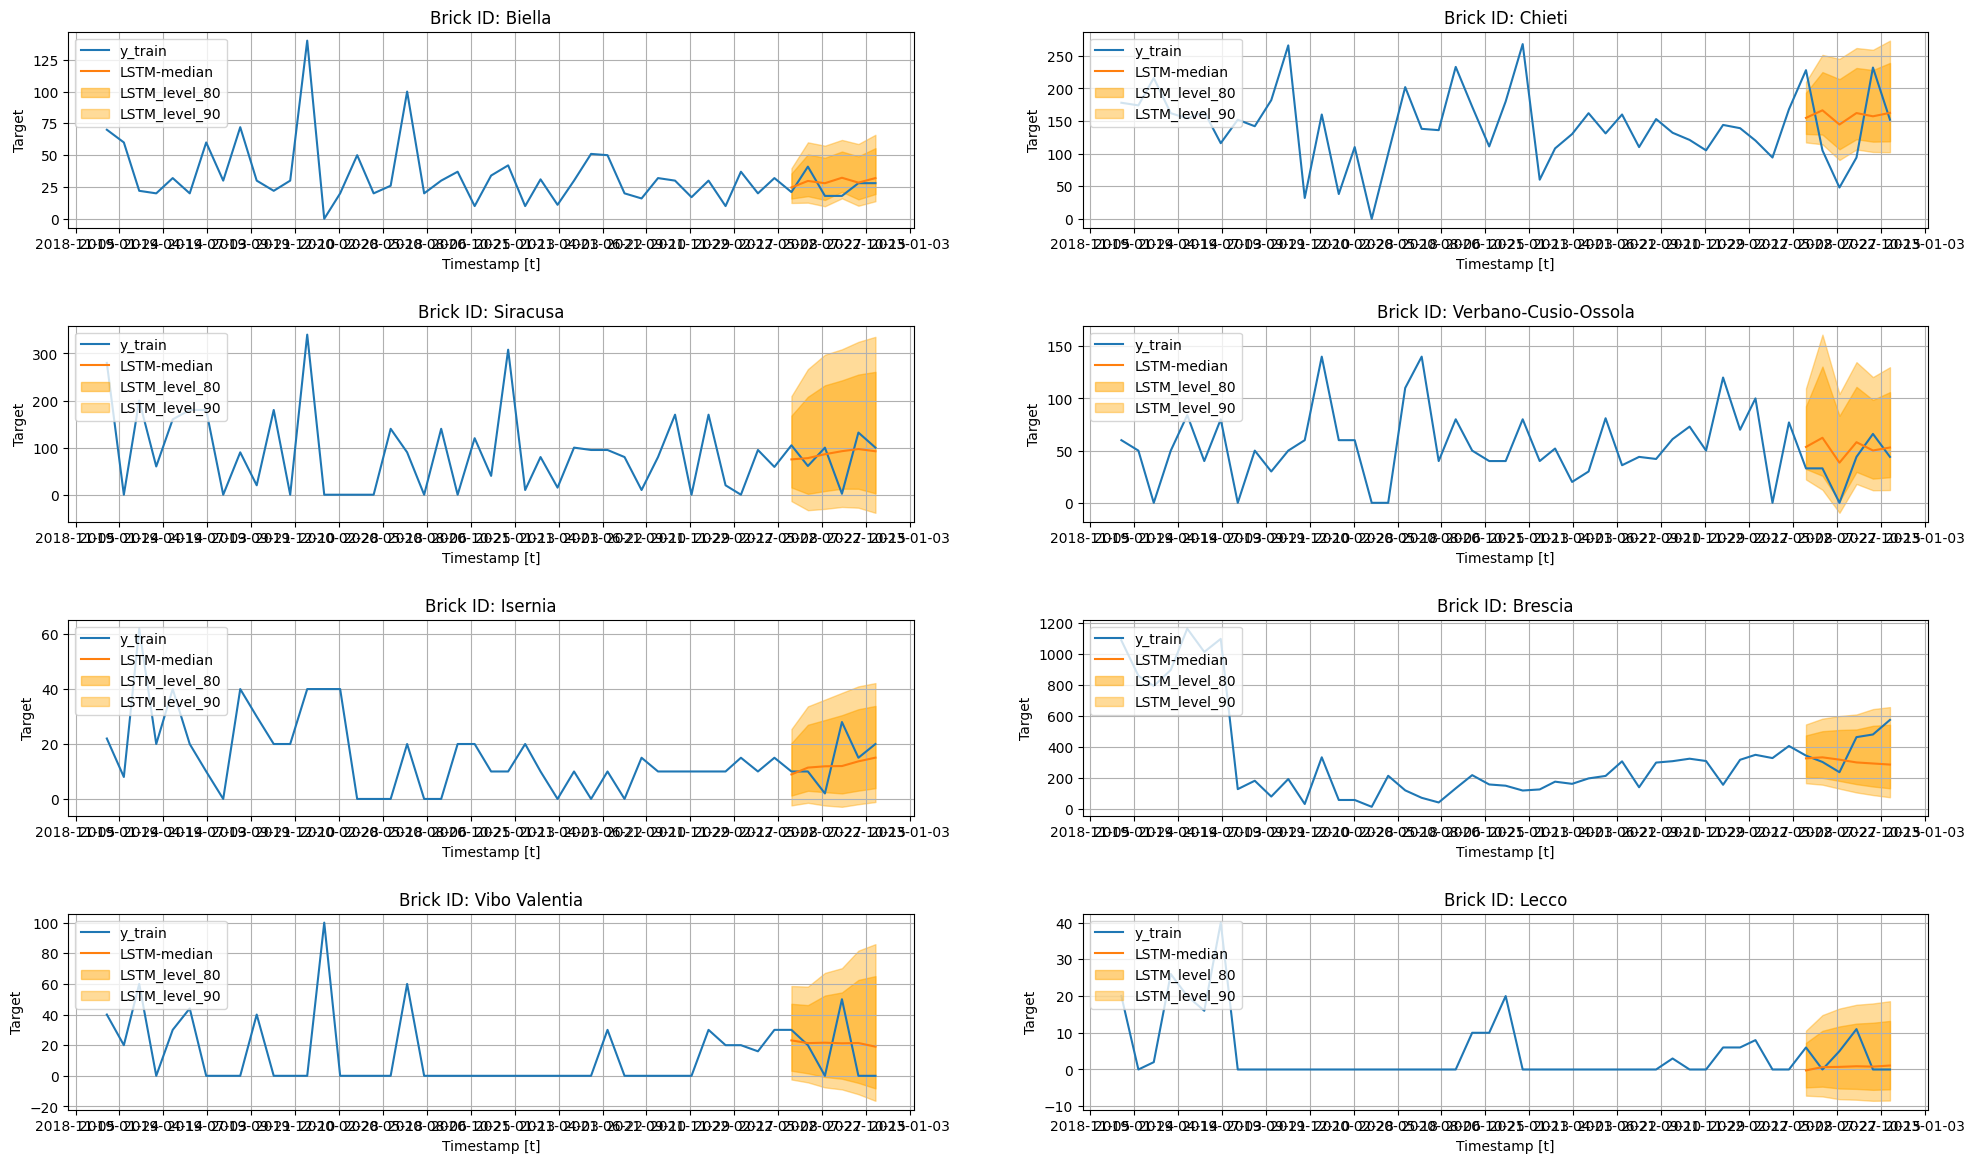

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 2355, in ray._raylet._auto_reconnect.wrapper
  File "python/ray/_raylet.pyx", line 2502, in ray._raylet.GcsClient.internal_kv_del
  File "python/ray/_raylet.pyx", line 455, in ray._raylet.check_status
ray.exceptions.RpcError: failed to connect to all addresses; last error: UNKNOWN: ipv4:10.123.138.232:58668: Failed to connect to remote host: Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 984, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'grpc'


In [38]:
levels=[80, 90]

plot_grid(df_nixtla_new, y_hat_new, level=levels, model='LSTM')

In [22]:
gr_pred = y_hat_new.groupby('ds')[['LSTM-median', 'LSTM-lo-90', 'LSTM-hi-90']].sum().reset_index()
gr_true = df_nixtla_new[(df_nixtla_new.ds>'2022-05-01')].groupby('ds').y.sum().reset_index()

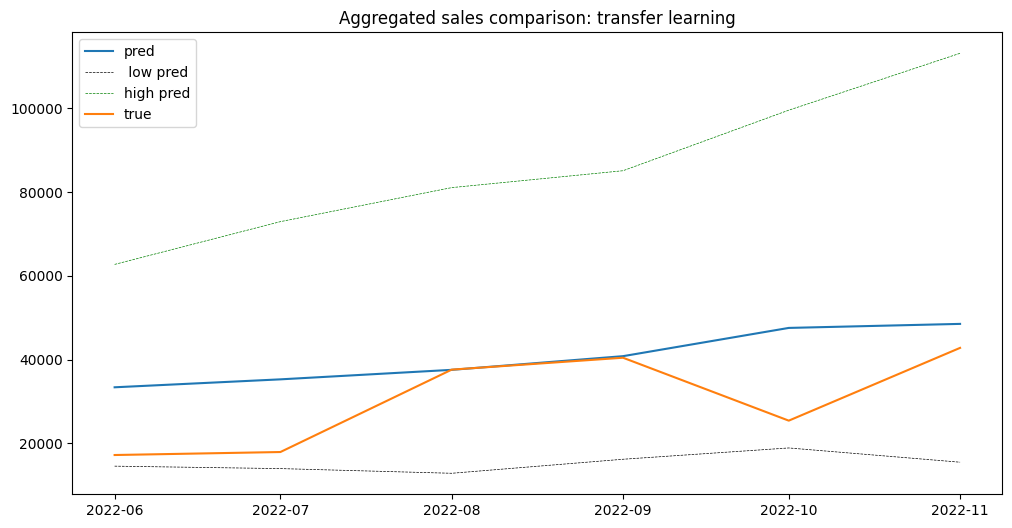

In [27]:
plt.figure(figsize=(12,6))
plt.plot(gr_pred.ds, gr_pred['LSTM-median'], label='pred')
plt.plot(gr_pred.ds, gr_pred['LSTM-lo-90'], ls='--', color='black', lw=.5, label='low pred')
plt.plot(gr_pred.ds, gr_pred['LSTM-hi-90'], ls='--', color='green', lw=.5, label='high pred')
plt.plot(gr_true.ds, gr_true['y'], label='true')
plt.title('Aggregated sales comparison: transfer learning')
plt.legend()
plt.show()